In [1]:
import pyspark
from pyspark.ml import Pipeline
import pandas as pd
import statsmodels.api as sm

import numpy as np # linear algebra
import os
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com').getOrCreate()

In [3]:
spark

In [4]:
# Read csv file
df_housing = spark.read.csv("Housing.csv",header=True)

#Show csv file
print(df_housing)

#Displaying the first 3 rows of Housing data
print("\n\n",df_housing.head(3))

#Displaying number of Rows and columns in given dataset
print("\nNumber Of Rows in Given Data",df_housing.count())
print("\nNumber Of Columns in Given Data",len(df_housing.columns))

DataFrame[longitude: string, latitude: string, housing_median_age: string, total_rooms: string, total_bedrooms: string, population: string, households: string, median_income: string, median_house_value: string, ocean_proximity: string]


 [Row(longitude='-122.23', latitude='37.88', housing_median_age='41.0', total_rooms='880.0', total_bedrooms='129.0', population='322.0', households='126.0', median_income='8.3252', median_house_value='452600.0', ocean_proximity='NEAR BAY'), Row(longitude='-122.22', latitude='37.86', housing_median_age='21.0', total_rooms='7099.0', total_bedrooms='1106.0', population='2401.0', households='1138.0', median_income='8.3014', median_house_value='358500.0', ocean_proximity='NEAR BAY'), Row(longitude='-122.24', latitude='37.85', housing_median_age='52.0', total_rooms='1467.0', total_bedrooms='190.0', population='496.0', households='177.0', median_income='7.2574', median_house_value='352100.0', ocean_proximity='NEAR BAY')]

Number Of Rows in Given Data 20640

N

In [5]:
#Create Database using HIVE
spark.sql("create database if not exists Housing")
db=spark.sql("show databases")
db.show()
# Drop Table if EXISTS using Hive
spark.sql('drop table IF EXISTS housing')
#Creating Table to store Data
df_housing.write.saveAsTable("housing")

# Display the data from table
df_housing1=spark.sql("select * from housing limit 5")
print(type(df_housing))

df_housing1.show()
df_housing=spark.sql("select * from housing limit")

#df.printSchema()
df_housing1.printSchema()

df_housing1.columns


+---------+
|namespace|
+---------+
|  default|
|  housing|
+---------+

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|      

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [6]:
#Checking datatype of each column
pd.DataFrame(df_housing.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,longitude,string
1,latitude,string
2,housing_median_age,string
3,total_rooms,string
4,total_bedrooms,string
5,population,string
6,households,string
7,median_income,string
8,median_house_value,string
9,ocean_proximity,string


In [7]:
df_housing = df_housing.withColumn("longitude", df_housing["longitude"].cast(DoubleType()))
df_housing = df_housing.withColumn("housing_median_age", df_housing["housing_median_age"].cast(DoubleType()))
df_housing = df_housing.withColumn("latitude", df_housing["latitude"].cast(DoubleType()))
df_housing = df_housing.withColumn("total_rooms", df_housing["total_rooms"].cast(DoubleType()))
df_housing = df_housing.withColumn("total_bedrooms", df_housing["total_bedrooms"].cast(DoubleType()))
df_housing= df_housing.withColumn("population", df_housing["population"].cast(DoubleType()))
df_housing = df_housing.withColumn("households", df_housing["households"].cast(DoubleType()))
df_housing = df_housing.withColumn("median_income", df_housing["median_income"].cast(DoubleType()))
df_housing = df_housing.withColumn("median_house_value", df_housing["median_house_value"].cast(DoubleType()))

In [8]:
#column overview
pd.DataFrame(df_housing.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [9]:
#Checking data entries for each column
df_housing.select(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms']).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|
+-------+-------------------+-----------------+------------------+------------------+------------------+



In [10]:
df_housing.select(['population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']).describe().show()

+-------+------------------+-----------------+------------------+------------------+---------------+
|summary|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+------------------+-----------------+------------------+------------------+---------------+
|  count|             20640|            20640|             20640|             20640|          20640|
|   mean|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  1132.46212176534|382.3297528316098| 1.899821717945263|115395.61587441359|           NULL|
|    min|               3.0|              1.0|            0.4999|           14999.0|      <1H OCEAN|
|    max|           35682.0|           6082.0|           15.0001|          500001.0|     NEAR OCEAN|
+-------+------------------+-----------------+------------------+------------------+---------------+



In [12]:
df_housing.select(['longitude']).show()

+---------+
|longitude|
+---------+
|  -122.23|
|  -122.22|
|  -122.24|
|  -122.25|
|  -122.25|
|  -122.25|
|  -122.25|
|  -122.25|
|  -122.26|
|  -122.25|
|  -122.26|
|  -122.26|
|  -122.26|
|  -122.26|
|  -122.26|
|  -122.26|
|  -122.27|
|  -122.27|
|  -122.26|
|  -122.27|
+---------+
only showing top 20 rows



In [13]:
#Check any missing value
for column in df_housing.columns:
    print(column, df_housing.filter(col(column).cast("float").isin([None,np.nan])).count())

#no null values in the dataframe

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [14]:
df_housing = df_housing.withColumnRenamed('median_house_value','price')

In [15]:
df_housing.na.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, price: double, ocean_proximity: string]

In [16]:
type(df_housing['price'])

pyspark.sql.column.Column

C:\Users\Mohammed Maaz Sibhai\AppData\Local\Temp\ipykernel_20244\213006843.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('price').toPandas(), color="skyblue")


+------------------+------------------+
|   skewness(price)|   kurtosis(price)|
+------------------+------------------+
|0.9776922140978437|0.3275001388119674|
+------------------+------------------+



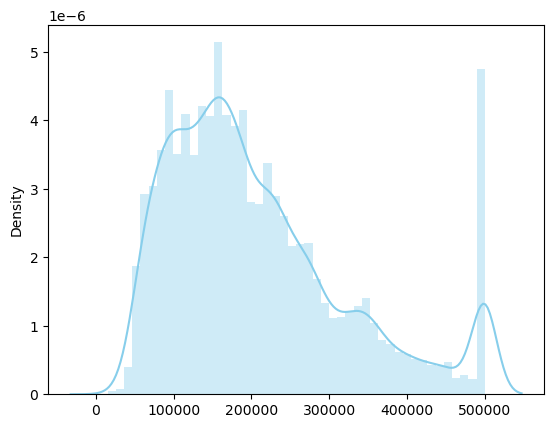

In [17]:
#Checking if the prices are normally distributed
sns.distplot(df_housing.select('price').toPandas(), color="skyblue")
df_housing.select(F.skewness('price'), F.kurtosis('price')).show()

In [18]:
#Housing prices greater than 500,000 (expensive houses)
print("No of houses: %i" % df_housing.select('price').count())
print("No of houses greater than $500000 are: %i" % df_housing.filter(df_housing["price"] > 500000).count())

No of houses: 20640
No of houses greater than $500000 are: 965


<Axes: ylabel='Count'>

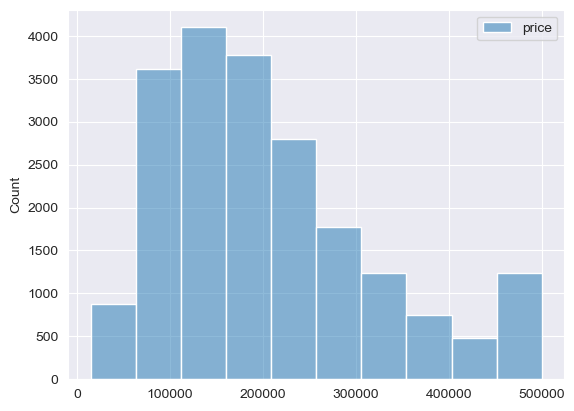

In [19]:
#Distribution of prices
sns.set_style("darkgrid")
sns.histplot(df_housing.select('price').toPandas(), bins = 10)

<Axes: xlabel='total_rooms', ylabel='avg(price)'>

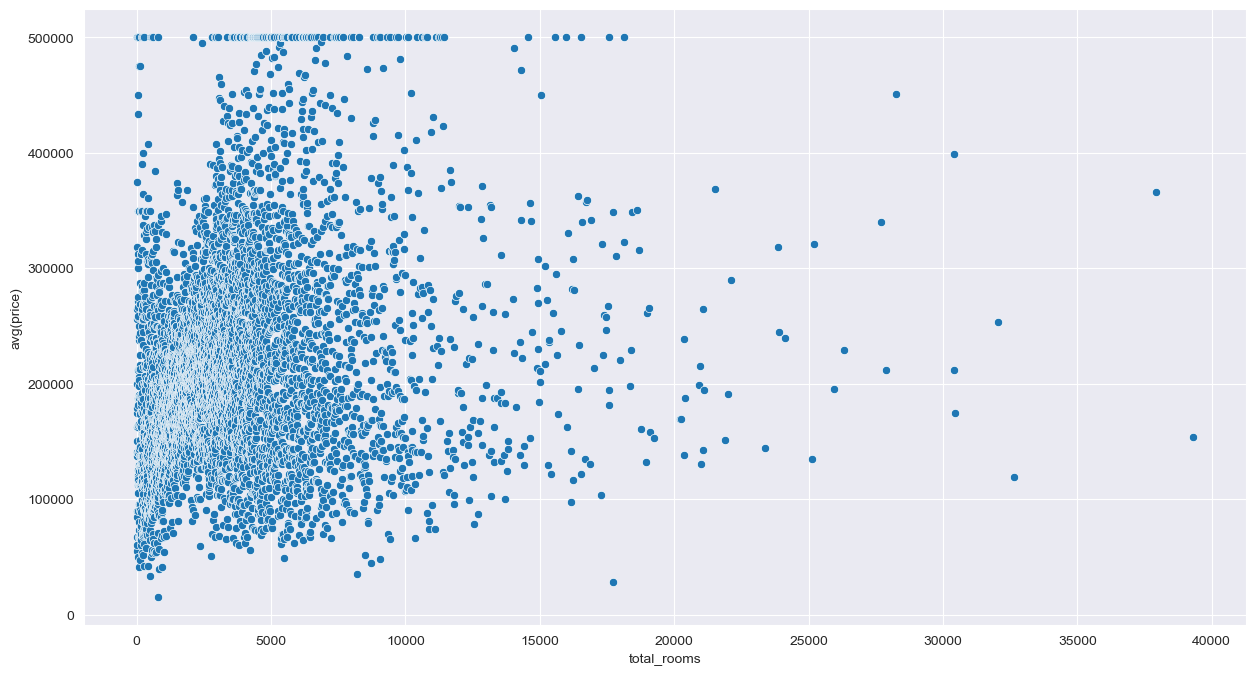

In [20]:
#Average price of house
import matplotlib.pyplot as plt
df1 = df_housing.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(price)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(price)'] )

In [21]:
df_housing = df_housing.withColumn('per_capita_income', df_housing['median_income']*10000/df_housing['population'])

[(0.0, 500.0)]

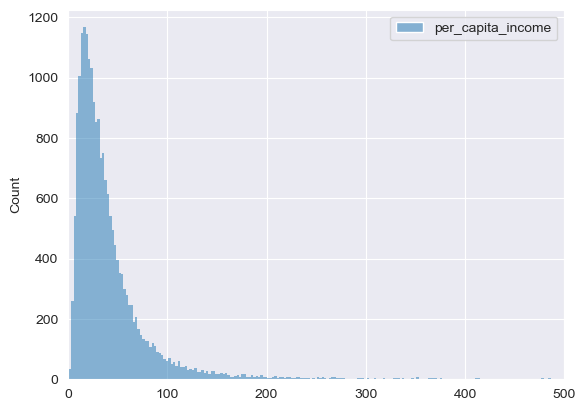

In [22]:
#per_capita_income distribution 
g = sns.histplot(df_housing.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))

<Axes: xlabel='per_capita_income', ylabel='price'>

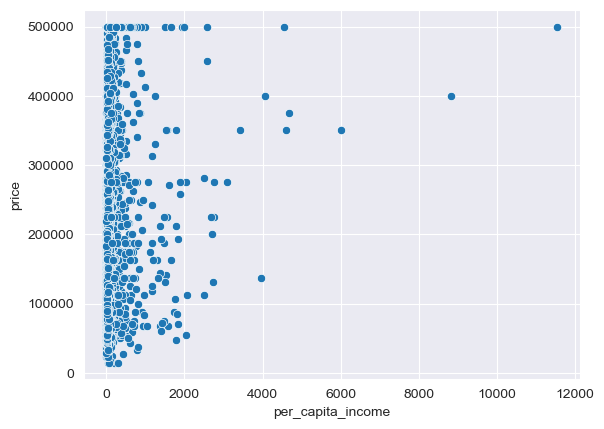

In [23]:
#Per-capita-income and prices of the home
df_p = df_housing.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['price'])

#A lot of data has near $100 per-capita income - data is skewed towards zero. 

In [24]:
#Counting per capita that are less than $100
count_blocks = df_housing.filter('per_capita_income <  100').count()/df_housing.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 92.596899


In [25]:
#Checking unique values in ocean_proximity
df_housing.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



<Axes: xlabel='ocean_proximity', ylabel='avg(median_income)'>

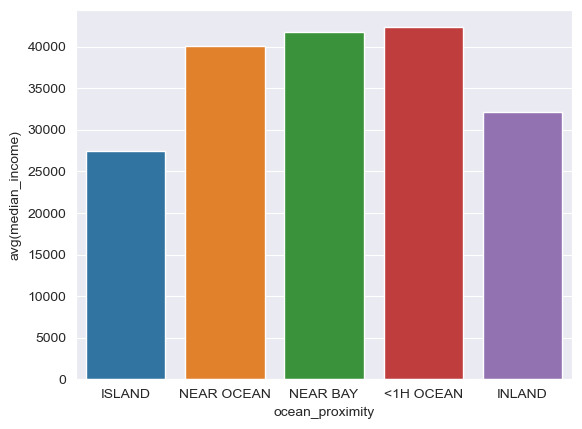

In [26]:
#Where does wealthy people live?
df_i = df_housing.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)


In [27]:
#Label-encoding for the "ocean_proximity" column
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index") 
df_housing = indexer.fit(df_housing).transform(df_housing)
df_housing = df_housing.drop('ocean_proximity')
df_housing.select('ocean_proximity_index').show(3)

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows



In [28]:
#Removing na values to ensure correlation method works properly
mean = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
df_housing = df_housing.na.fill({'total_bedrooms': mean})

In [29]:
#Checking if na values exist in 'total_bedrooms' columns
df_housing.filter(col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|price|per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+



<Axes: >

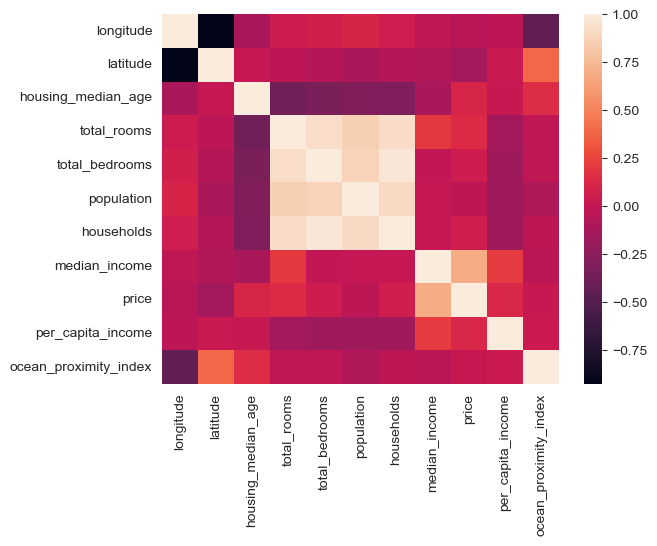

In [30]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df_housing.columns, outputCol="features")
df_vector = assembler.transform(df_housing).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df_housing.columns, index = df_housing.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr)

In [31]:
#Drop non-correlated columns
df_model = df_housing.select(['housing_median_age','total_rooms', 'median_income','price'])
df_model.show(3)

+------------------+-----------+-------------+--------+
|housing_median_age|total_rooms|median_income|   price|
+------------------+-----------+-------------+--------+
|              41.0|      880.0|       8.3252|452600.0|
|              21.0|     7099.0|       8.3014|358500.0|
|              52.0|     1467.0|       7.2574|352100.0|
+------------------+-----------+-------------+--------+
only showing top 3 rows



C:\Users\Mohammed Maaz Sibhai\AppData\Local\Temp\ipykernel_20244\1132552312.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('housing_median_age').toPandas(), color="skyblue")


+----------------------------+----------------------------+
|skewness(housing_median_age)|kurtosis(housing_median_age)|
+----------------------------+----------------------------+
|        0.060326253016608676|         -0.8007255995445028|
+----------------------------+----------------------------+



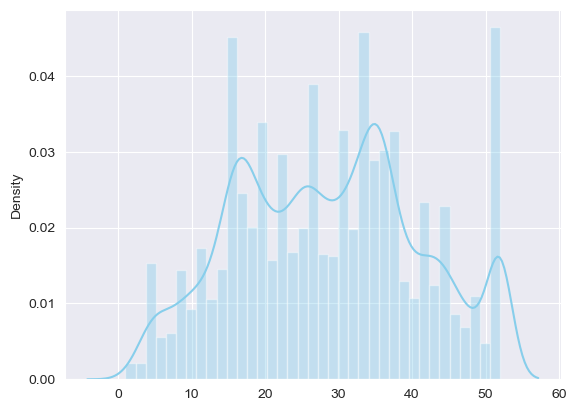

In [32]:

sns.distplot(df_housing.select('housing_median_age').toPandas(), color="skyblue")
df_housing.select(F.skewness('housing_median_age'), F.kurtosis('housing_median_age')).show()

#the housing_median_age is normally distributed

C:\Users\Mohammed Maaz Sibhai\AppData\Local\Temp\ipykernel_20244\3221832100.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('total_rooms').toPandas(), color="skyblue")


+---------------------+---------------------+
|skewness(total_rooms)|kurtosis(total_rooms)|
+---------------------+---------------------+
|    4.147042038773302|    32.62273207294906|
+---------------------+---------------------+



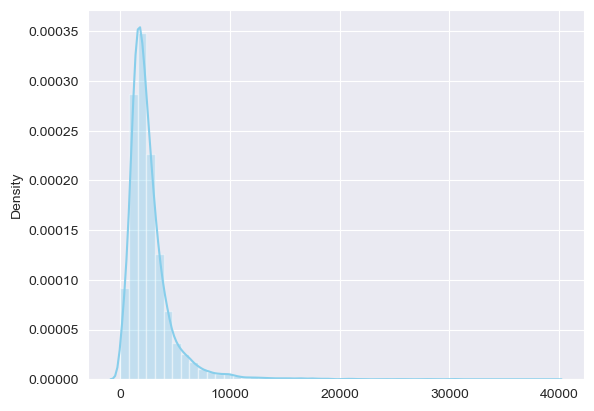

In [33]:
#Checking normal distribution of selected fetures
#total_rooms

sns.distplot(df_housing.select('total_rooms').toPandas(), color="skyblue")
df_housing.select(F.skewness('total_rooms'), F.kurtosis('total_rooms')).show()

#the total_rooms is not normally distributed

C:\Users\Mohammed Maaz Sibhai\AppData\Local\Temp\ipykernel_20244\2087977227.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model.select('total_rooms_log').toPandas(), color="skyblue")


+-------------------------+-------------------------+
|skewness(total_rooms_log)|kurtosis(total_rooms_log)|
+-------------------------+-------------------------+
|      -1.0972584854175316|         5.25204961078785|
+-------------------------+-------------------------+



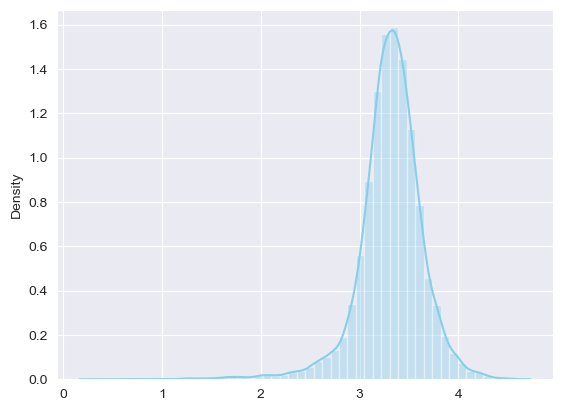

In [34]:
#Using lograthimic scale to normalize the data

df_model = df_model.withColumn("total_rooms_log", F.log10(col("total_rooms")))

sns.distplot(df_model.select('total_rooms_log').toPandas(), color="skyblue")
df_model.select(F.skewness('total_rooms_log'), F.kurtosis('total_rooms_log')).show()


C:\Users\Mohammed Maaz Sibhai\AppData\Local\Temp\ipykernel_20244\1229512019.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('median_income').toPandas(), color="skyblue")


+-----------------------+-----------------------+
|skewness(median_income)|kurtosis(median_income)|
+-----------------------+-----------------------+
|     1.6465370299001063|      4.951033760409806|
+-----------------------+-----------------------+



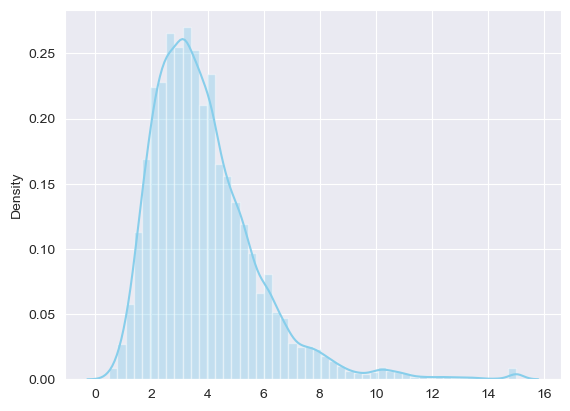

In [35]:
#Checking normal distribution of selected fetures
#median_income

sns.distplot(df_housing.select('median_income').toPandas(), color="skyblue")
df_housing.select(F.skewness('median_income'), F.kurtosis('median_income')).show()

In [36]:
spark.sql('drop table IF EXISTS df_model_final')
#Creating Table to store Data
df_housing.write.saveAsTable("df_model_final")
df_model_final = spark.sql("select * from df_model_final limit 5")

df_model_final.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price| per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|258.54658385093165|                  3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0| 34.57476051645147|                  3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|146.31854838709677|                  3.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     

In [37]:
#Assembling features
feature_assembly = VectorAssembler(inputCols = ['housing_median_age','total_rooms_log', 'median_income'], outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+------------------+-----------+-------------+--------+------------------+--------------------+
|housing_median_age|total_rooms|median_income|   price|   total_rooms_log|            features|
+------------------+-----------+-------------+--------+------------------+--------------------+
|              41.0|      880.0|       8.3252|452600.0|2.9444826721501687|[41.0,2.944482672...|
|              21.0|     7099.0|       8.3014|358500.0|3.8511971761741606|[21.0,3.851197176...|
|              52.0|     1467.0|       7.2574|352100.0| 3.166430113843283|[52.0,3.166430113...|
+------------------+-----------+-------------+--------+------------------+--------------------+
only showing top 3 rows



In [38]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|   price|   total_rooms_log|            features|      scaledFeatures|
+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|452600.0|2.9444826721501687|[41.0,2.944482672...|[3.25770230160830...|
|              21.0|     7099.0|       8.3014|358500.0|3.8511971761741606|[21.0,3.851197176...|[1.66857922765303...|
|              52.0|     1467.0|       7.2574|352100.0| 3.166430113843283|[52.0,3.166430113...|[4.13171999228370...|
+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
only showing top 3 rows



In [39]:
df_model_final = scaledOutput.select(['price', 'scaledFeatures'])
df_model_final.show(3)
# Drop Table if EXISTS using Hive
spark.sql('drop table IF EXISTS scaledOutput')
#Creating Table to store Data
scaledOutput.write.saveAsTable("scaledOutput")
scaledOutput = spark.sql("select * from scaledOutput")

scaledOutput.show()


+--------+--------------------+
|   price|      scaledFeatures|
+--------+--------------------+
|452600.0|[3.25770230160830...|
|358500.0|[1.66857922765303...|
|352100.0|[4.13171999228370...|
+--------+--------------------+
only showing top 3 rows

+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|   price|   total_rooms_log|            features|      scaledFeatures|
+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|452600.0|2.9444826721501687|[41.0,2.944482672...|[3.25770230160830...|
|              21.0|     7099.0|       8.3014|358500.0|3.8511971761741606|[21.0,3.851197176...|[1.66857922765303...|
|              52.0|     1467.0|       7.2574|352100.0| 3.166430113843283|[52.0,3.166430113...|[4.13171999228370...|
|              52.0|     1274.0|       5.6431|341

In [40]:
from pyspark.ml.regression import LinearRegression 

#test train split
df_train, df_test = df_model_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'price')
regressor = regressor.fit(df_train)

In [41]:
#Checking train performance

pred_results = regressor.evaluate(df_train)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 60296.881732
The r2 for the model is: 0.516934


In [42]:
#Checking train performance
pred_results = regressor.evaluate(df_test)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 59519.016413
The r2 for the model is: 0.509083
